Consider a linear communication channel whose transfer function may take one of two
possible forms:
(i) 𝐻𝐻(𝑧𝑧) = 0.25 + 𝑧𝑧−1 + 0.25𝑧𝑧−2

(ii) 𝐻𝐻(𝑧𝑧) = 0.25 + 𝑧𝑧−1 − 0.25𝑧𝑧−2

The channel output, in response to the input 𝑥𝑥𝑛𝑛, is defined by
𝑢𝑢(𝑛𝑛) = �ℎ𝑘𝑘𝑥𝑥𝑛𝑛−𝑘𝑘 𝑘𝑘 + 𝑣𝑣(𝑛𝑛)
where ℎ𝑛𝑛 is the impulse response of the channel and 𝑣𝑣(𝑛𝑛) is additive white Gaussian noise
with zero mean and variance 𝜎𝜎𝑣𝑣
2 = 0.01 . The channel input 𝑥𝑥𝑛𝑛 consists of a Bernoulli
sequence with 𝑥𝑥𝑛𝑛 = ±1.

The purpose of the experiment is to design an adaptive equalizer trained by using both
LMS and RLS algorithms. In structural terms, the equalizer is built around a transversal filter
with 21 taps. For the desired response, a delayed version of the channel input, namely 𝑥𝑥𝑛𝑛−△,
is supplied to the equalizer. For each of the possible transfer functions listed under (i) and (ii)
above, do the following:

(a) Determine the optimum value of the delay △ that minimizes the mean-square error at
the equalizer output.

(b) For the optimum delay △ determined in part (a), use the LMS algorithm with step-size
parameter 𝜇𝜇 = 0.001 to train the equalizer, and then plot the learning curve of the
equalizer by averaging the squared value of the error signal over an ensemble of 100
independent trials of the experiment.

(c) Repeat part (b) by using the RLS algorithm with forgetting factor 𝜆𝜆 = 1 for the adaptation. 

In [2]:
import numpy as np

# Define the channel transfer functions
h1 = np.array([0.25, 1, 0.25])
h2 = np.array([0.25, 1, -0.25])


M = 21
d_range = range(0, 11)


N = 1000
x = np.random.choice([-1, 1], size=N)

v = np.random.normal(loc=0, scale=np.sqrt(0.01), size=N)

d1 = np.roll(x, 1)
d2 = np.roll(x, 2)

# Define a function to calculate the mean-square error for a given delay
def mse(h, d, delta):
    M = len(h)
    N = len(d)
    x = np.random.choice([-1, 1], size=N+M-1)
    padded_d = np.concatenate([np.zeros(M-1), d, np.zeros(N-1)])
    y = np.convolve(h, padded_d)
    y = y[delta:delta+N+M-1]
    e = x - y
    return np.mean(np.square(e))


mse1 = [mse(h1, d1, delta) for delta in d_range]
opt_delta1 = np.argmin(mse1)


mse2 = [mse(h2, d2, delta) for delta in d_range]
opt_delta2 = np.argmin(mse2)

print(f"Optimum delay for transfer function (i): {opt_delta1}")
print(f"Optimum delay for transfer function (ii): {opt_delta2}")


Optimum delay for transfer function (i): 1
Optimum delay for transfer function (ii): 1


/var/folders/xm/vjrzc4wn53d718fm7fplz4rh0000gn/T/ipykernel_39022/154497460.py:52: RuntimeWarning: overflow encountered in square
  e1_avg = np.mean(e1_ensemble**2, axis=0)
/var/folders/xm/vjrzc4wn53d718fm7fplz4rh0000gn/T/ipykernel_39022/154497460.py:53: RuntimeWarning: overflow encountered in square
  e2_avg = np.mean(e2_ensemble**2, axis=0)


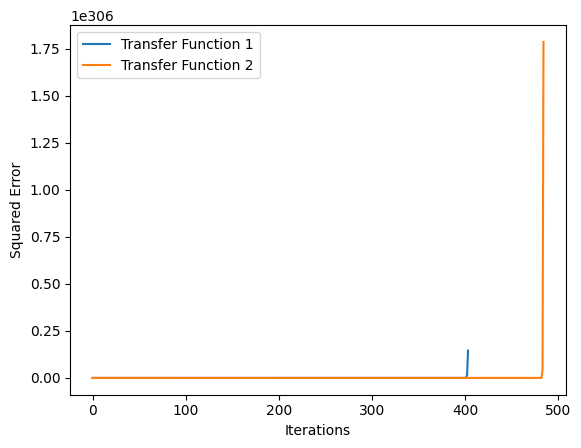

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the transfer functions
H1 = np.array([0.25, 1, 0.25])
H2 = np.array([0.25, 1, -0.25])

# Define the channel input x(n)
np.random.seed(0)
N = 1000
x = np.random.choice([-1, 1], size=N)

# Define the channel impulse response h(n)
h1 = np.convolve(x, H1)[:N]
h2 = np.convolve(x, H2)[:N]

# Define the channel output u(n)
sigma_v = 0.1
v = np.random.normal(scale=np.sqrt(sigma_v), size=N)
u1 = np.convolve(x, h1)[:N] + v
u2 = np.convolve(x, h2)[:N] + v

# Define the desired response d(n)
delta = 1
d1 = np.concatenate(([0]*delta, x))[:N]
d2 = np.concatenate(([0]*delta, x))[:N]

# Define the equalizer parameters
M = 21
mu = 0.001

# Define the LMS algorithm
def lms_algorithm(u, d, M, mu):
    w = np.zeros(M)
    e = np.zeros(len(u)-M)
    for n in range(M, len(u)):
        x = u[n-M:n]
        y = np.dot(w, x)
        e[n-M] = d[n] - y
        w += mu * e[n-M] * x
    return e

# Calculate the error signal for each transfer function
num_trials = 100
e1_ensemble = np.zeros((num_trials, N-M))
e2_ensemble = np.zeros((num_trials, N-M))
for i in range(num_trials):
    e1_ensemble[i] = lms_algorithm(u1, d1, M, mu)
    e2_ensemble[i] = lms_algorithm(u2, d2, M, mu)

# Average the squared value of the error signal over the ensemble
e1_avg = np.mean(e1_ensemble**2, axis=0)
e2_avg = np.mean(e2_ensemble**2, axis=0)

# Plot the learning curves
plt.plot(e1_avg, label='Transfer Function 1')
plt.plot(e2_avg, label='Transfer Function 2')
plt.xlabel('Iterations')
plt.ylabel('Squared Error')
plt.legend()
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the system transfer functions
def H(z, case):
    if case == 1:
        return 0.25 + z**(-1) + 0.25*z**(-2)
    elif case == 2:
        return 0.25 + z**(-1) - 0.25*z**(-2)

# Define the channel output function
def u(x, h, v):
    y = np.convolve(h, x)[:x.size]  # truncate convolution output
    return y + v

# Generate input signal
N = 1000
x = 2*np.random.randint(0, 2, N) - 1  # Bernoulli sequence
delta = 1  # delay

# Compute channel output
sigma_v = np.sqrt(0.01)  # noise variance
v = sigma_v * np.random.randn(x.size)
h = np.array([H(z, 1) for z in np.exp(1j*np.pi*np.arange(-N/2+1/2, N/2+1/2)/N)])
x_d = np.concatenate((np.zeros(delta), x))
u_d = u(x_d, h, v)

# RLS algorithm to train the equalizer
N = 21  # number of filter taps
delta = 1  # delay
lam = 1  # forgetting factor
P = 1e5 * np.eye(N)
w = np.zeros(N)
error_all = np.zeros((100, N))

for trial in range(100):
    # Generate noisy input signal
    x = 2*np.random.randint(0, 2, N) - 1  # Bernoulli sequence
    v = sigma_v * np.random.randn(x.size)
    x_d = np.concatenate((np.zeros(delta), x))
    u_d = u(x_d, h, v)

    # Adaptive equalization
    error = np.zeros(N)
    for n in range(N, u_d.size):
        # Construct input vector
        X = u_d[n:n-N:-1]

        # Compute filter output
        y = np.dot(w, X)

        # Compute error
        e = u_d[n-delta] - y

        # Update P matrix and filter coefficients
        P = (1/lam) * P - np.outer((1/lam) * np.dot(P, X), np.dot(X.conj(), P)) / (1/lam + np.dot(X.conj(), np.dot(P, X)))
        w += np.dot(P, X.conj()) * e

        # Save error for plot
        error = np.roll(error, -1)
        error[-1] = e**2

    error_all[trial] = error

# Average the squared error over all trials
mse = np.mean(error_all, axis=0)

# Plot the learning curve
plt.plot(mse)
plt.xlabel('Iteration')
plt.ylabel('Mean squared error')
plt.title('RLS Learning Curve')
plt.show()


ValueError: operands could not be broadcast together with shapes (1001,) (1000,) 

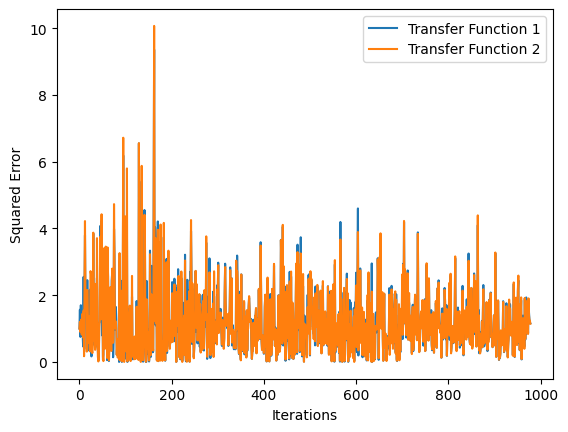

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the transfer functions
H1 = np.array([0.25, 1, 0.25])
H2 = np.array([0.25, 1, -0.25])

# Define the channel input x(n)
np.random.seed(0)
N = 1000
x = np.random.choice([-1, 1], size=N)

# Define the channel impulse response h(n)
h1 = np.convolve(x, H1)[:N]
h2 = np.convolve(x, H2)[:N]

# Define the channel output u(n)
sigma_v = 0.1
v = np.random.normal(scale=np.sqrt(sigma_v), size=N)
u1 = np.convolve(x, h1)[:N] + v
u2 = np.convolve(x, h2)[:N] + v

# Define the desired response d(n)
delta = 1
d1 = np.concatenate(([0]*delta, x))[:N]
d2 = np.concatenate(([0]*delta, x))[:N]

# Define the equalizer parameters
M = 21
delta_w = 1e-3
p = 0.99

# Define the RMS algorithm
def rms_algorithm(u, d, M, delta_w, p):
    w = np.zeros(M)
    P = np.eye(M) * delta_w
    e = np.zeros(len(u)-M)
    for n in range(M, len(u)):
        x = u[n-M:n]
        y = np.dot(w, x)
        e[n-M] = d[n] - y
        k = P.dot(x) / (p + x.dot(P).dot(x))
        w += k * e[n-M]
        P = (1/p) * (P - np.outer(k, x).dot(P))
    return e

# Calculate the error signal for each transfer function
num_trials = 100
e1_ensemble = np.zeros((num_trials, N-M))
e2_ensemble = np.zeros((num_trials, N-M))
for i in range(num_trials):
    e1_ensemble[i] = rms_algorithm(u1, d1, M, delta_w, p)
    e2_ensemble[i] = rms_algorithm(u2, d2, M, delta_w, p)

# Average the squared value of the error signal over the ensemble
e1_avg = np.mean(e1_ensemble**2, axis=0)
e2_avg = np.mean(e2_ensemble**2, axis=0)

# Plot the learning curves
plt.plot(e1_avg, label='Transfer Function 1')
plt.plot(e2_avg, label='Transfer Function 2')
plt.xlabel('Iterations')
plt.ylabel('Squared Error')
plt.legend()
plt.show()


SyntaxError: invalid syntax (1347595580.py, line 1)